In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
np.random.seed(7)

In [6]:
folder_dir = '../data/'
data_path = "data_clean.csv"
data = pd.read_csv(filepath_or_buffer= folder_dir + data_path, header=0)
data=data.drop('Unnamed: 0',axis=1)

In [7]:
data.shape

(3700449, 37)

In [8]:
data.columns

Index(['date', 'umpcall', 'outcome', 'start_speed', 'pfx_x', 'pfx_z', 'px',
       'pz', 'break_y', 'break_angle', 'break_length', 'pitch_type',
       'spin_dir', 'nasty', 'pitch_count', 'descr', 'y', 'year', 'count_b_p',
       'strikes', 'balls', 'pitcher', 'pitch_type.1', 'rolling_start_speed',
       'long_rolling_start_speed', 'zone_1', 'zone_2', 'zone_3', 'zone_4',
       'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12',
       'zone_13'],
      dtype='object')

In [9]:
data['dist']=np.sqrt(data['px']**2+data['pz']**2)
data['speed_diff']=data['rolling_start_speed']-data['long_rolling_start_speed']

In [10]:
pitch_types=pd.get_dummies(data['pitch_type'],prefix='pitch_type')
data=pd.concat([data,pitch_types],axis=1)
pitch_types=0

In [11]:
# model_feats=['px','pz','pfx_x','pfx_z','start_speed',
#              'spin_dir','pitch_count','balls','strikes','date',
#              'y','rolling_start_speed']

model_feats=['px','pz','pfx_x','pfx_z','start_speed','spin_dir',
             'pitch_count','balls','strikes','date',
             'y','speed_diff','pitch_type_CH', 
             'pitch_type_CU','pitch_type_FC', 'pitch_type_FF', 
             'pitch_type_FS', 'pitch_type_FT', 'pitch_type_KC', 
             'pitch_type_SI', 'pitch_type_SL']

# model_feats=['px','pz','pfx_x','pfx_z','y','strikes','date']

In [12]:
import datetime

data["date"] = pd.to_datetime(data["date"])

start = data["date"].searchsorted(datetime.datetime(2012, 1, 1))[0]
#start
end = data["date"].searchsorted(datetime.datetime(2016, 1, 1))[0] - 1
#end

X_train = data[model_feats].loc[start:end]
y_train=X_train['y']
X_train=X_train.drop(['y','date'],axis=1)

X_test=data[model_feats][end:]
y_test=X_test['y']
X_test=X_test.drop(['y','date'],axis=1)
data=0

# Fully Connected Neural Net

In [45]:
X_train.shape

(3221706, 20)

In [46]:
X_train.shape[1]

20

In [47]:
len(model_feats)

22

In [48]:
input_dim = X_train.shape[1]

In [49]:
from keras.layers import PReLU

In [50]:
model = Sequential()
model.add(Dense(30, input_dim=input_dim, activation='relu'))
#model.add(Dropout(rate = 0.1, noise_shape=None, seed=None))
model.add(Dense(20, activation='relu'))
#model.add(Dropout(rate = 0.1, noise_shape=None, seed=None))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [51]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [52]:
model.fit(x = X_train, 
          y = y_train, 
          epochs=15, 
          batch_size=32)

Epoch 1/15
3221706/3221706 [==============================] - 120s 37us/step - loss: 0.5074 - acc: 0.7569TA: - ETA: 0s - loss: 0
Epoch 2/15
3221706/3221706 [==============================] - 120s 37us/step - loss: 0.4808 - acc: 0.7794 1s - loss:
Epoch 3/15
3221706/3221706 [==============================] - 182s 57us/step - loss: 0.4783 - acc: 0.7810
Epoch 4/15
3221706/3221706 [==============================] - 181s 56us/step - loss: 0.4769 - acc: 0.7819
Epoch 5/15
3221706/3221706 [==============================] - 177s 55us/step - loss: 0.4761 - acc: 0.7825
Epoch 6/15
3221706/3221706 [==============================] - 175s 54us/step - loss: 0.4756 - acc: 0.7827
Epoch 7/15
3221706/3221706 [==============================] - 183s 57us/step - loss: 0.4753 - acc: 0.7832
Epoch 8/15
3221706/3221706 [==============================] - 180s 56us/step - loss: 0.4748 - acc: 0.7834
Epoch 9/15
3221706/3221706 [==============================] - 179s 56us/step - loss: 0.4746 - acc: 0.7835
Epoch 10/15


In [63]:
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

478744/478744 [==============================] - 14s 30us/step

acc: 78.33%


In [65]:
X_test.shape

(478744, 20)

In [84]:
probs=model.predict_proba(X_test)
preds = (probs> 0.5).astype(int).flatten()
np.savetxt('probs_NN.csv', probs, delimiter=',')

In [68]:
loglog_loss=log_loss(y_test,probs)
loglog_loss

0.4751132463350911

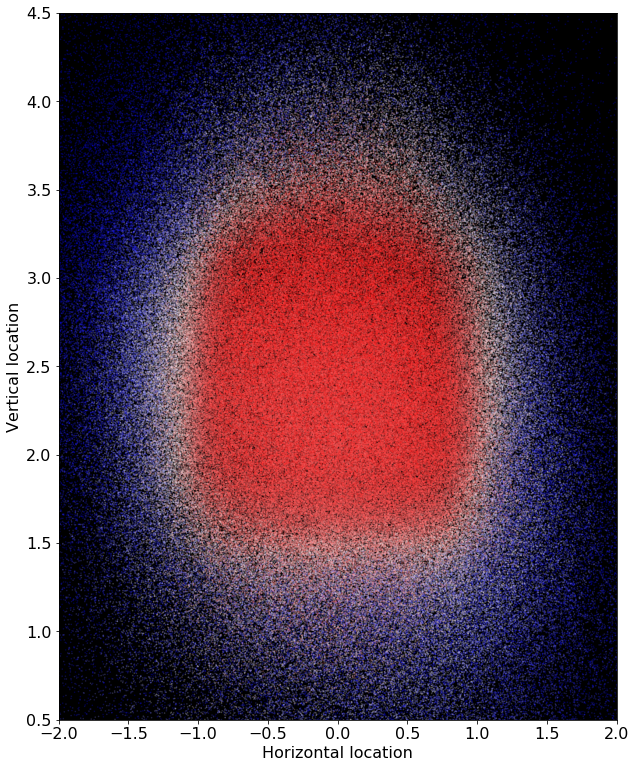

In [70]:
plt.rcParams['axes.facecolor'] = "black"
plt.figure(figsize=(10,13))
plt.xlim(-2.0,2.0)
plt.ylim(0.5,4.5)
plt.scatter(X_test['px'],X_test['pz'],s=0.5, c=probs, 
            alpha=0.2, cmap='bwr');
plt.xlabel('Horizontal location',fontsize=16)
plt.ylabel('Vertical location',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.legend(('Bad Pitch', 'Good Pitch'), loc='best', fontsize=16)
plt.savefig('predictions_class_NN.jpg', dpi = 100)

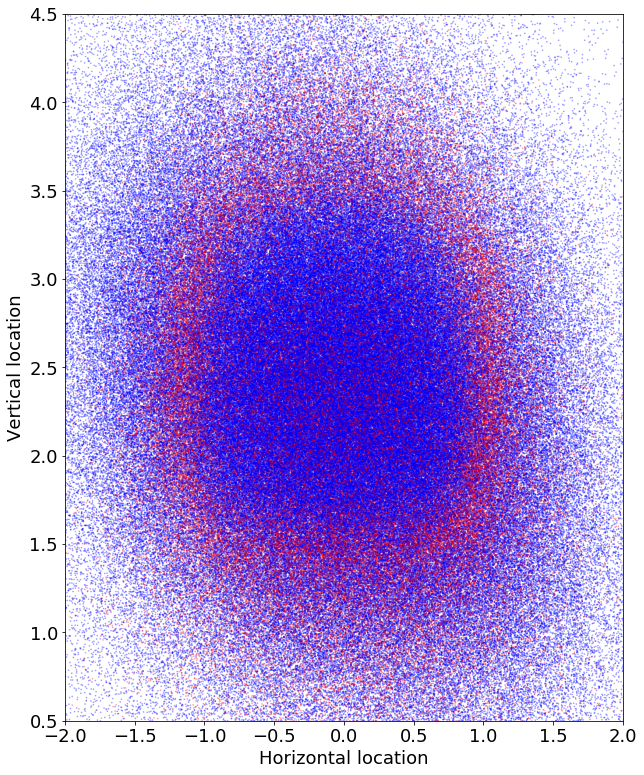

In [71]:
if_wrong_predictions = np.array(preds != y_test).astype(int)
plt.close("all")
plt.rcParams['axes.facecolor'] = 'white'

plt.figure(figsize=(10,13))
plt.xlim(-2,2)
plt.ylim(0.5,4.5)

plt.scatter(X_test['px'],X_test['pz'],s=.5, c=if_wrong_predictions, alpha=0.3, cmap='bwr');

plt.xlabel('Horizontal location',fontsize=18)
plt.ylabel('Vertical location',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.savefig('errors_NN.jpg', format='jpg', dpi=100)

## Error analysis 

In [26]:
myindex=X_test.index.values
probs=np.genfromtxt('probs_NN.csv',delimiter=',')
#probs=pd.read_csv('probs_NN.csv',header=None).as_array()
preds = (probs> 0.5).astype(int)
probs=pd.DataFrame(probs,index=myindex, columns=['probs'])
preds=pd.DataFrame(preds,index=myindex,columns=['preds'])
data_err=pd.concat([X_test,y_test,probs,preds],axis=1)

data_err['wrong']=np.where(data_err['y']==data_err['preds'],0,1)
 #'alert'] = np.where(df.used == 1, 'Full', np.where(df.used == 0, 'Empty', 'Partial'))
data_err.head()

,px,pz,pfx_x,pfx_z,start_speed,spin_dir,pitch_count,balls,strikes,speed_diff,...,pitch_type_FF,pitch_type_FS,pitch_type_FT,pitch_type_KC,pitch_type_SI,pitch_type_SL,y,probs,preds,wrong
3221705,-0.063,1.521,0.71,3.71,80.9,169.326,34,0,1,0.1585,...,0,0,0,0,0,1,0,0.736858,1,1
3221706,0.134,1.451,0.90,1.68,79.1,152.632,1,0,0,0.1585,...,0,0,0,0,0,1,1,0.661354,1,0
3221707,-0.936,2.343,1.20,2.71,81.1,156.463,2,0,1,0.1585,...,0,0,0,0,0,1,1,0.706630,1,0
3221708,-0.526,5.090,4.62,6.92,90.0,146.399,3,0,2,0.1585,...,1,0,0,0,0,0,0,0.006133,0,0
3221709,0.711,5.031,9.30,5.23,90.2,119.545,4,1,2,0.1585,...,1,0,0,0,0,0,0,0.003636,0,0


In [27]:
data_err.describe()

,px,pz,pfx_x,pfx_z,start_speed,spin_dir,pitch_count,balls,strikes,speed_diff,...,pitch_type_FF,pitch_type_FS,pitch_type_FT,pitch_type_KC,pitch_type_SI,pitch_type_SL,y,probs,preds,wrong
count,478744.000000,478744.000000,478744.000000,478744.000000,478744.000000,478744.000000,478744.000000,478744.000000,478744.000000,478744.000000,...,478744.000000,478744.000000,478744.000000,478744.000000,478744.000000,478744.000000,478744.000000,478744.000000,478744.000000,478744.000000
mean,-0.039635,2.288297,-1.514978,4.927394,87.698516,179.781702,36.382248,0.874304,0.878290,-0.169329,...,0.349180,0.011764,0.111389,0.021291,0.098155,0.151168,0.554576,0.584164,0.663244,0.216730
std,0.874695,0.918023,5.972937,5.666590,6.185955,67.616516,29.597412,0.962326,0.823733,2.013795,...,0.476712,0.107823,0.314614,0.144353,0.297524,0.358213,0.497013,0.294038,0.472601,0.412017
min,-8.010000,-4.061160,-28.091700,-22.345400,46.600000,-0.002000,1.000000,0.000000,0.000000,-14.428500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.643928,1.702000,-6.390000,2.120000,83.700000,140.994750,11.000000,0.000000,0.000000,-0.895000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.338325,0.000000,0.000000
50%,-0.030000,2.291335,-2.460000,6.250000,88.800000,197.958500,28.000000,1.000000,1.000000,-0.065500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.735553,1.000000,0.000000
75%,0.570000,2.880000,2.960000,9.080000,92.500000,223.451000,59.000000,1.000000,2.000000,0.732500,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.817096,1.000000,0.000000
max,6.031500,7.551870,18.690000,21.901400,101.900000,360.000000,132.000000,4.000000,2.000000,11.515500,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.961082,1.000000,1.000000


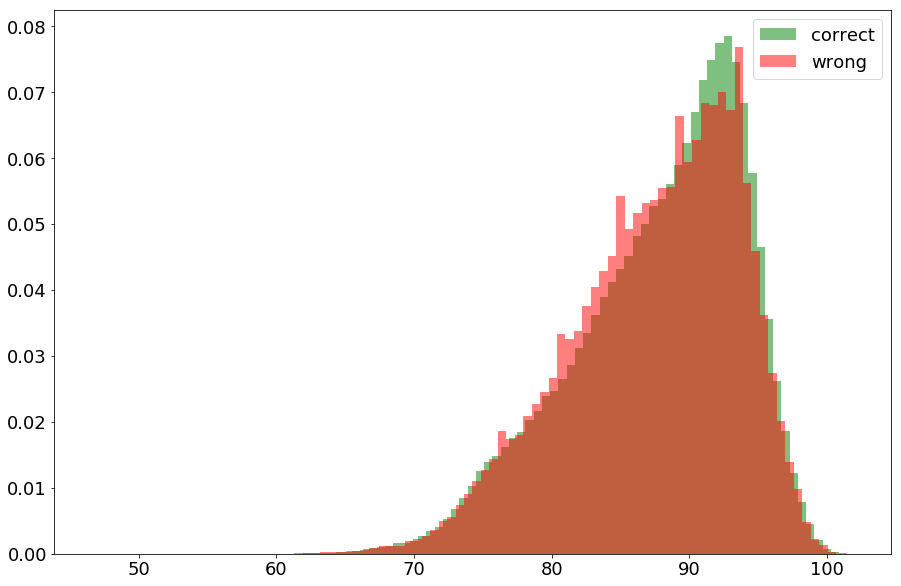

In [67]:
num_bins=90
plt.figure(figsize=(15,10))
plt.hist(data_err['start_speed'][data_err['wrong']==0],bins=num_bins,alpha=0.5,label='correct',normed=True,color='g')
plt.hist(data_err['start_speed'][data_err['wrong']==1],bins=num_bins,alpha=0.5,label='wrong',normed=True,color='r')
plt.legend(loc='best',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('speed_hist.jpg',format='jpg', dpi=100)
plt.show()

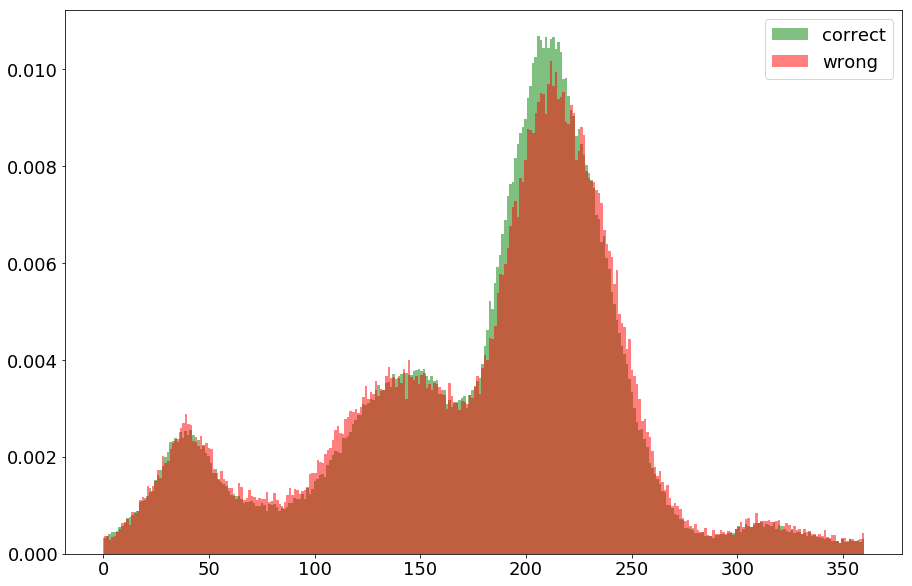

In [60]:
num_bins=300
plt.figure(figsize=(15,10))
plt.hist(data_err['spin_dir'][data_err['wrong']==0],bins=num_bins,alpha=0.5,label='correct',normed=True,color='g')
plt.hist(data_err['spin_dir'][data_err['wrong']==1],bins=num_bins,alpha=0.5,label='wrong',normed=True,color='r')
plt.legend(loc='best',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('spin_hist.jpg',format='jpg', dpi=100)
plt.show()

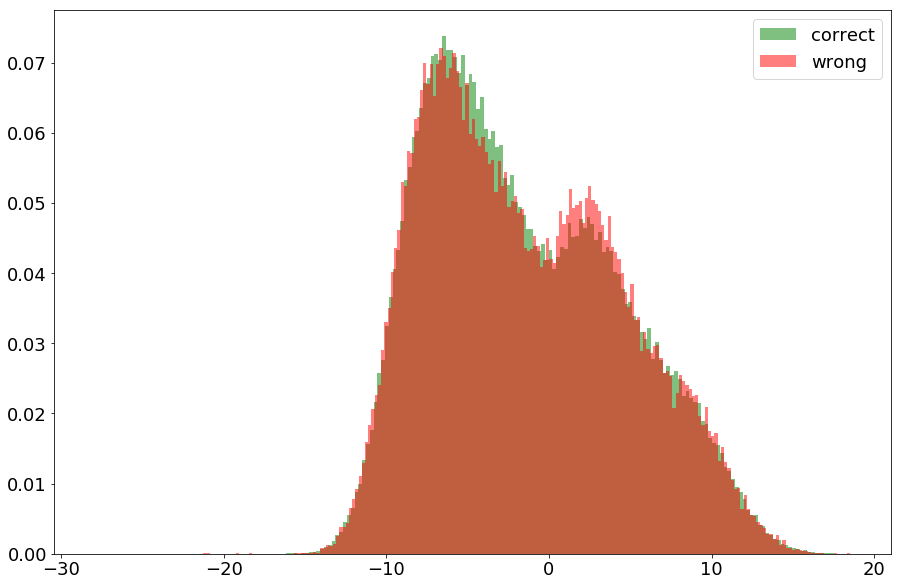

In [95]:
num_bins=200
plt.figure(figsize=(15,10))
plt.hist(data_err['pfx_x'][data_err['wrong']==0],bins=num_bins,alpha=0.5,label='correct',normed=True,color='g')
plt.hist(data_err['pfx_x'][data_err['wrong']==1],bins=num_bins,alpha=0.5,label='wrong',normed=True,color='r')
plt.legend(loc='best',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('movx_hist.jpg',format='jpg', dpi=100)
plt.show()

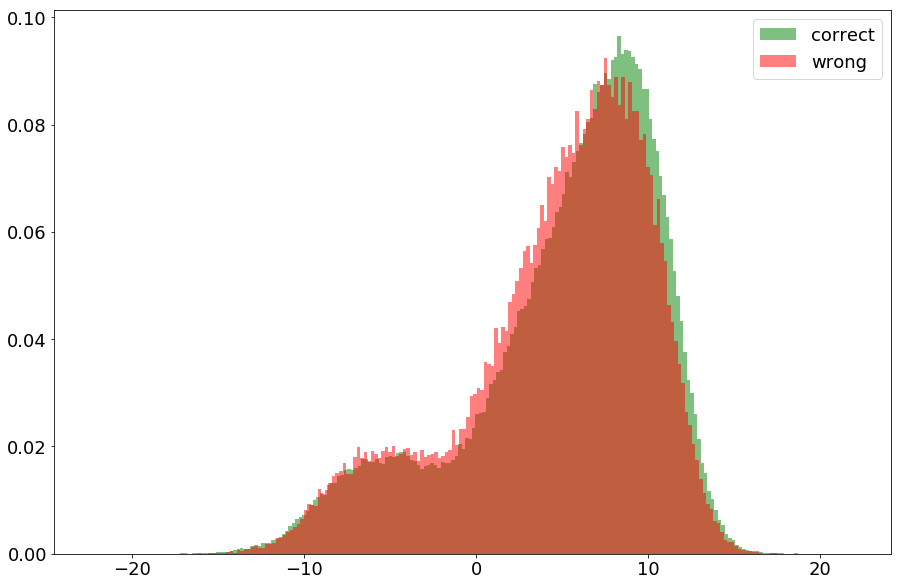

In [96]:
num_bins=200
plt.figure(figsize=(15,10))
plt.hist(data_err['pfx_z'][data_err['wrong']==0],bins=num_bins,alpha=0.5,label='correct',normed=True,color='g')
plt.hist(data_err['pfx_z'][data_err['wrong']==1],bins=num_bins,alpha=0.5,label='wrong',normed=True,color='r')
plt.legend(loc='best',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('movz_hist.jpg',format='jpg', dpi=100)
plt.show()

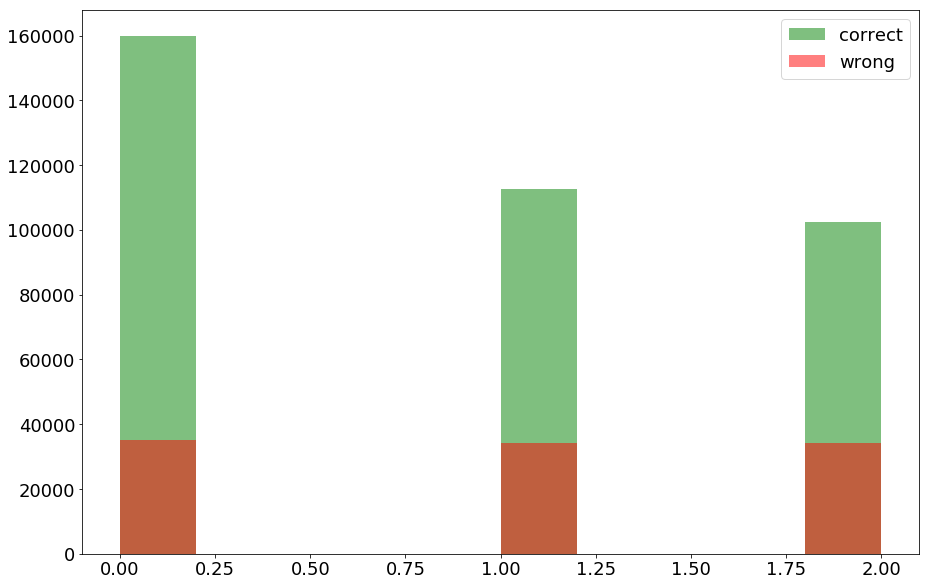

In [94]:
#num_bins=auto
plt.figure(figsize=(15,10))
plt.hist(data_err['strikes'][data_err['wrong']==0],alpha=0.5,label='correct',normed=False,color='g')
plt.hist(data_err['strikes'][data_err['wrong']==1],alpha=0.5,label='wrong',normed=False,color='r')
plt.legend(loc='best',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('stikes_hist.jpg',format='jpg', dpi=100)
plt.show()

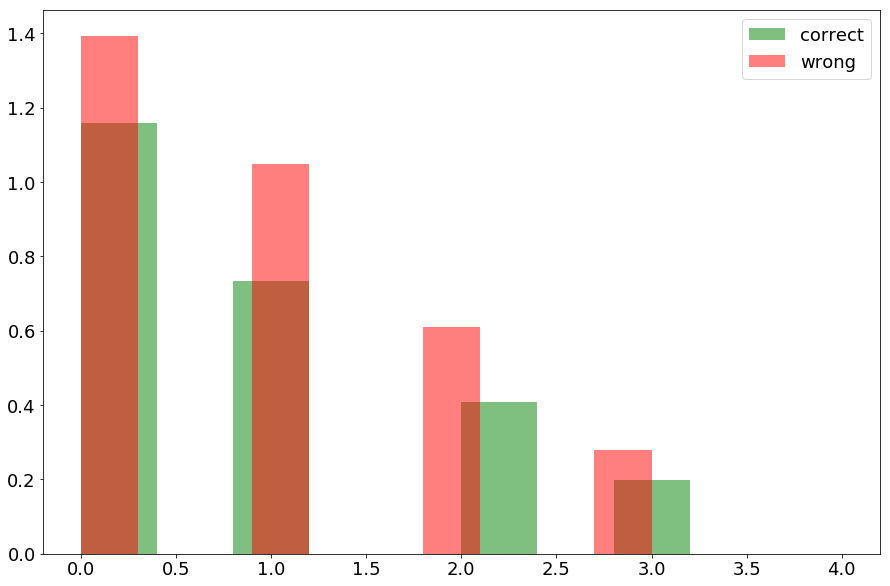

In [85]:
plt.figure(figsize=(15,10))
plt.hist(data_err['balls'][data_err['wrong']==0],alpha=0.5,label='correct',normed=True,color='g')
plt.hist(data_err['balls'][data_err['wrong']==1],alpha=0.5,label='wrong',normed=True,color='r')
plt.legend(loc='best',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('balls_hist.jpg',format='jpg', dpi=100)
plt.show()

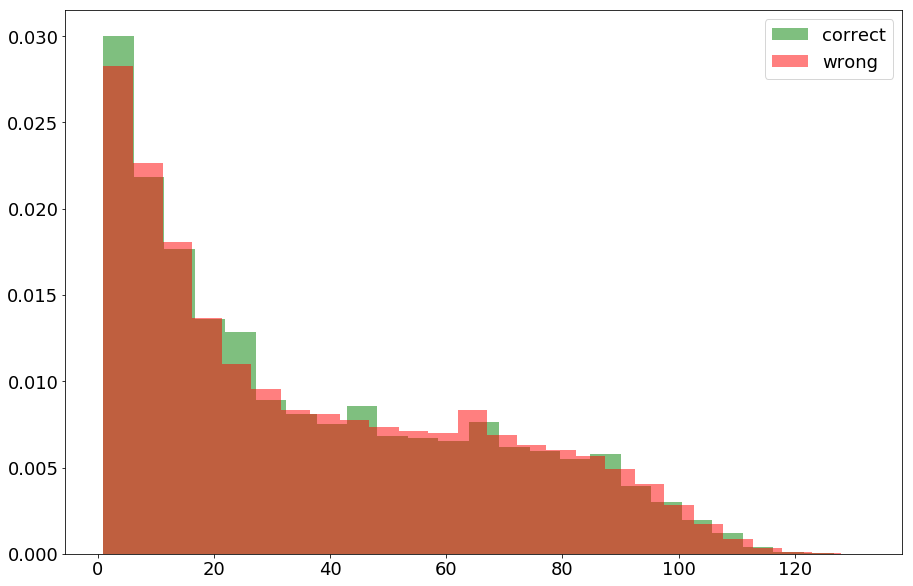

In [93]:
num_bins=25
plt.figure(figsize=(15,10))
plt.hist(data_err['pitch_count'][data_err['wrong']==0],bins=num_bins,alpha=0.5,label='correct',normed=True,color='g')
plt.hist(data_err['pitch_count'][data_err['wrong']==1],bins=num_bins,alpha=0.5,label='wrong',normed=True,color='r')
plt.legend(loc='best',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('count_hist.jpg',format='jpg', dpi=100)
plt.show()

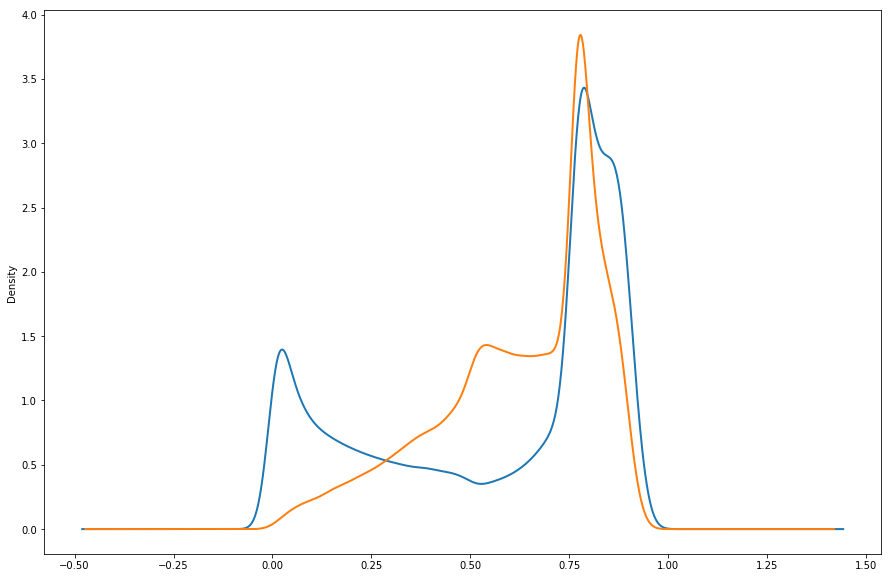

In [46]:
#data = data.loc[data['px'] >= -2]
#data['probs']
plt.figure(figsize=(15,10))
data_err['probs'][data_err['wrong']==0].plot.kde(linewidth=2)
data_err['probs'][data_err['wrong']==1].plot.kde(linewidth=2)
plt.savefig('densities.jpg')

# Neural Net 2

In [ ]:
model2 = Sequential()
model2.add(Dense(40, input_dim=input_dim, activation='relu'))
#model.add(Dropout(rate = 0.1, noise_shape=None, seed=None))
model2.add(Dense(40, activation='relu'))
#model.add(Dropout(rate = 0.1, noise_shape=None, seed=None))
model2.add(Dense(20, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model2.fit(x = X_train, 
          y = y_train, 
          epochs=50, 
          batch_size=50)

In [ ]:
scores = model2.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))